In [298]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import regularizers

In [405]:
from google.colab import files
uploaded = files.upload()

Saving ionosphere_data.csv to ionosphere_data (3).csv


In [406]:
import io
df = pd.read_csv(io.BytesIO(uploaded["ionosphere_data.csv"]))

**Verifying the Data**

In [407]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 35 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature1   351 non-null    int64  
 1   feature2   351 non-null    int64  
 2   feature3   351 non-null    float64
 3   feature4   351 non-null    float64
 4   feature5   351 non-null    float64
 5   feature6   351 non-null    float64
 6   feature7   351 non-null    float64
 7   feature8   351 non-null    float64
 8   feature9   351 non-null    float64
 9   feature10  351 non-null    float64
 10  feature11  351 non-null    float64
 11  feature12  351 non-null    float64
 12  feature13  351 non-null    float64
 13  feature14  351 non-null    float64
 14  feature15  351 non-null    float64
 15  feature16  351 non-null    float64
 16  feature17  351 non-null    float64
 17  feature18  351 non-null    float64
 18  feature19  351 non-null    float64
 19  feature20  351 non-null    float64
 20  feature21 

In [408]:
normalized_data=df.copy()
normalized_data.shape

(351, 35)

In [409]:
normalized_data[normalized_data.duplicated()]

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,label
248,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,b


In [410]:
normalized_data.drop_duplicates(inplace = True)
normalized_data.shape

(350, 35)

In [411]:
normalized_data["feature2"].value_counts()

0    350
Name: feature2, dtype: int64

In [412]:
normalized_data.drop(columns=["feature2"], inplace = True)
normalized_data.shape

(350, 34)

In [413]:
data = normalized_data # sample(normalized_data.shape[0], random_state=1)
data.shape

(350, 34)

In [414]:
class_g = data[data["label"]=="g"]
class_b = data[data["label"]=="b"]

In [415]:
class_g.shape

(225, 34)

In [416]:
class_b.shape

(125, 34)

In [418]:
data_over = pd.concat([class_b, class_g], axis=0)

In [419]:
data_over["label"].value_counts()

g    225
b    125
Name: label, dtype: int64

In [420]:
len(data_over)

350

**Splitting the Traing and Testing data**

In [421]:
x_data = data_over.sample(frac=1) # Shuffling the data
train_data_full= x_data.iloc[:210,:]
test_data_full = x_data.iloc[210:, :]
train_data = train_data_full.iloc[:, :-1]
train_labels = train_data_full.iloc[:, -1]
test_data = test_data_full.iloc[:, :-1]
test_labels = test_data_full.iloc[:, -1]

In [422]:
print(train_data.shape)
print(test_data.shape)
print(train_labels.shape)
print(test_labels.shape)

(210, 33)
(140, 33)
(210,)
(140,)


In [423]:
train_data.shape, test_data.shape

((210, 33), (140, 33))

In [424]:
train_labels.shape, test_labels.shape

((210,), (140,))

**Normalizing the data**

In [425]:
mean = train_data.mean(axis=0)
train_data -=mean
std =train_data.std(axis=0)
train_data /=std

test_data -=mean
test_data /=std

In [426]:
train_labels = np.where(train_labels =="g", 1, 0 )
test_labels = np.where(test_labels =="g",1,0)

train_labels=np.asarray(train_labels).astype(dtype="float64")
test_labels=np.asarray(test_labels).astype(dtype="float64")

**Building the Network**

In [427]:
def build_model():
  model=models.Sequential()
  model.add(layers.Dense(16,kernel_regularizer=regularizers.l1_l2(l1=.002, l2=0.004) , activation="relu", input_shape=(train_data.shape[1],)))
  model.add(layers.Dropout(.5))
  model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=.002, l2=0.004), activation = "relu" ))
  model.add(layers.Dropout(.3))
  model.add(layers.Dense(1, activation="sigmoid"))

  model.compile(optimizer="rmsprop", loss = "binary_crossentropy", metrics=["accuracy"])
  return model

**K fold Validation**

In [428]:
k= 5
num_val_sample = len(train_data) // k
num_epochs =90
all_scores = []
all_val_loss_histories = []
all_val_acc_histories = []
all_loss_histories =[]
all_acc_histories = []

for i in range(k):
  print("processing fold #",i)
  val_data = train_data[i*num_val_sample:(i+1)*num_val_sample]
  val_labels = train_labels[i*num_val_sample: (i+1)*num_val_sample]

  partial_train_data=np.concatenate([train_data[:i*num_val_sample], train_data[(i+1)*num_val_sample:]], axis=0)
  partial_train_labels=np.concatenate([train_labels[:i*num_val_sample], train_labels[(i+1)*num_val_sample:]], axis=0)

  model=build_model()
  history = model.fit(partial_train_data, partial_train_labels, validation_data = (val_data, val_labels), batch_size=4, epochs= num_epochs, verbose=1)
  val_loss, val_acc = model.evaluate(test_data, test_labels, verbose=0)
  val_loss_history = history.history["val_loss"]
  val_acc_history = history.history["val_accuracy"]
  loss_history = history.history["loss"]
  acc_history = history.history["accuracy"]
  all_loss_histories.append(loss_history)
  all_acc_histories.append(acc_history)
  all_val_loss_histories.append(val_loss_history)
  all_val_acc_histories.append(val_acc_history)
  all_scores.append(val_acc)
ave_val_loss_hist = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]
ave_loss_hist = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
ave_val_acc_hist = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
ave_acc_hist = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
all_scores


processing fold # 0
Epoch 1/90
42/42 [==============================] - 1s 8ms/step - loss: 1.3160 - accuracy: 0.4708 - val_loss: 1.1028 - val_accuracy: 0.6905
Epoch 2/90
42/42 [==============================] - 0s 3ms/step - loss: 1.1267 - accuracy: 0.5336 - val_loss: 1.0457 - val_accuracy: 0.7381
Epoch 3/90
42/42 [==============================] - 0s 3ms/step - loss: 1.0396 - accuracy: 0.6904 - val_loss: 0.9969 - val_accuracy: 0.7619
Epoch 4/90
42/42 [==============================] - 0s 2ms/step - loss: 1.0155 - accuracy: 0.7238 - val_loss: 0.9511 - val_accuracy: 0.7619
Epoch 5/90
42/42 [==============================] - 0s 2ms/step - loss: 1.0528 - accuracy: 0.6421 - val_loss: 0.9118 - val_accuracy: 0.7857
Epoch 6/90
42/42 [==============================] - 0s 2ms/step - loss: 0.9692 - accuracy: 0.7749 - val_loss: 0.8885 - val_accuracy: 0.7857
Epoch 7/90
42/42 [==============================] - 0s 2ms/step - loss: 0.9434 - accuracy: 0.7115 - val_loss: 0.8603 - val_accuracy: 0.7857


[0.9142857193946838,
 0.9142857193946838,
 0.8999999761581421,
 0.9214285612106323,
 0.9071428775787354]

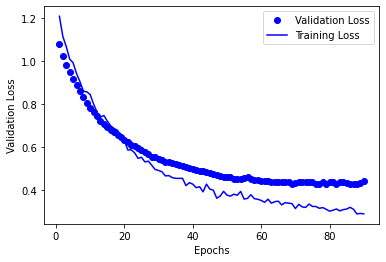

In [429]:
plt.plot(range(1, len(ave_val_loss_hist)+1)[:], ave_val_loss_hist[:], "bo", label="Validation Loss")
plt.plot(range(1, len(ave_val_loss_hist)+1)[:], ave_loss_hist[:], "b", label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()


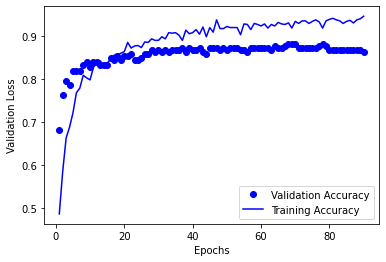

In [430]:
plt.plot(range(1, len(ave_val_acc_hist)+1)[:], ave_val_acc_hist[:], "bo", label="Validation Accuracy")
plt.plot(range(1, len(ave_val_acc_hist)+1)[:], ave_acc_hist[:], "b", label="Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

**Rebuilding the best fit Model**

In [432]:
model=models.Sequential()
model.add(layers.Dense(16,kernel_regularizer=regularizers.l1_l2(l1=.002, l2=0.004) , activation="relu", input_shape=(train_data.shape[1],)))
model.add(layers.Dropout(.5))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l1_l2(l1=.002, l2=0.004), activation = "relu" ))
model.add(layers.Dropout(.3))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer="rmsprop", loss = "binary_crossentropy", metrics=["accuracy"])

**Training the model with all samples**

In [433]:
model.fit(train_data, train_labels, epochs=90, batch_size=4)

Epoch 1/90
53/53 [==============================] - 1s 1ms/step - loss: 1.3465 - accuracy: 0.4438
Epoch 2/90
53/53 [==============================] - 0s 1ms/step - loss: 1.1081 - accuracy: 0.6240
Epoch 3/90
53/53 [==============================] - 0s 1ms/step - loss: 1.1081 - accuracy: 0.6013
Epoch 4/90
53/53 [==============================] - 0s 1ms/step - loss: 0.9903 - accuracy: 0.6882
Epoch 5/90
53/53 [==============================] - 0s 1ms/step - loss: 1.0409 - accuracy: 0.6766
Epoch 6/90
53/53 [==============================] - 0s 1ms/step - loss: 1.0148 - accuracy: 0.7004
Epoch 7/90
53/53 [==============================] - 0s 1ms/step - loss: 1.0340 - accuracy: 0.6747
Epoch 8/90
53/53 [==============================] - 0s 1ms/step - loss: 0.9278 - accuracy: 0.7132
Epoch 9/90
53/53 [==============================] - 0s 1ms/step - loss: 0.9103 - accuracy: 0.7364
Epoch 10/90
53/53 [==============================] - 0s 1ms/step - loss: 0.8394 - accuracy: 0.7880
Epoch 11/90
53/53 [

**Evaluating the Network**

In [434]:
test_loss_score, test_acc_score=model.evaluate(test_data, test_labels)

5/5 [==============================] - 0s 2ms/step - loss: 0.2960 - accuracy: 0.9286


In [435]:
test_acc_score *100

92.85714030265808

**Predicting the Network**

In [436]:
prediction=model.predict(test_data)
pred_norm =np.where(prediction>.5, 1, 0)
pred_norm=np.where(pred_norm==1, "g", "b")

In [437]:
pred_norm = pred_norm.reshape(pred_norm.shape[0],)
pred_norm[:10].T

array(['g', 'b', 'b', 'g', 'g', 'g', 'g', 'b', 'g', 'g'], dtype='<U1')

In [438]:
test_labels_new = np.where(test_labels==1, "g", "b")

In [439]:
test_labels_new[:10].T

array(['g', 'b', 'b', 'g', 'g', 'g', 'g', 'g', 'g', 'g'], dtype='<U1')

In [440]:
c= pred_norm.size
c

140

In [441]:
comapre_pred_test = test_labels_new == pred_norm

In [442]:
b = comapre_pred_test[comapre_pred_test[:]==True].size
b

130

In [443]:
a = comapre_pred_test[comapre_pred_test[:]==False].size
a

10

In [444]:
print("Incorrect Predictions are:", a, "and Correct predictions are :", b, " the percentage is:", round((b/c)*100,2), "%"  )

Incorrect Predictions are: 10 and Correct predictions are : 130  the percentage is: 92.86 %
